# 딥러닝 해보기
전처리
- min max

- model1 : 정적 동적 구분 () - Extra Trees Classifier
- model2-1 : 정적으로 구분한 것을 세부 Class 분류 
- model2-1 : 동적으로 구분한 것을 세부 Class 분류 

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 확인

In [83]:
# library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
import tensorflow as tf
import numpy as np
import random
import os

def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

In [85]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

In [123]:
# data 확인
# train_path = 'data/train_dataset.csv'
# test_path = 'data/test_dataset.csv'
# train_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/Kaggle_Competition/data/train_dataset.csv'
train_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/Kaggle_Competition/data/augmented_data_concat.csv'
test_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/Kaggle_Competition/data/test_dataset.csv'

train_data = pd.read_csv(train_path)
x_test = pd.read_csv(test_path)

train_data.shape, x_test.shape

((11123, 51), (1471, 50))

- Dynamic : 0, 1, 2 (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS)
- Static : 3, 4, 5 (LAYING, STANDING, SITTING)

In [124]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()
temp_x = train_data.drop('Activity_dynamic', axis=1)
temp_x = mm_scaler.fit_transform(temp_x)
x_test = pd.DataFrame(mm_scaler.transform(x_test), columns=list(x_test) )

orig_cols = list(train_data)[:-1]
temp_x = pd.DataFrame(temp_x, columns=[orig_cols])
temp_y = train_data[['Activity_dynamic']]

train_data = pd.concat([temp_x, temp_y], axis=1, join='outer')
train_data.columns = orig_cols + list(temp_y)

# 모델링

In [125]:
# x, y 분리
x = train_data.drop('Activity_dynamic', axis=1).values
y = train_data['Activity_dynamic'].values

In [126]:
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score

## is_dynamic 분류
- PyCaret 결과 : Extra Trees Classifier가 가장 좋았음

In [129]:
train_data['is_dynamic'] = np.where(train_data['Activity_dynamic'] < 3, 1, 0)

In [130]:
y_is_dy = train_data['is_dynamic'].values

In [131]:
from sklearn.ensemble import ExtraTreesClassifier

my_seed_everywhere(42)
model = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=42, verbose=0, warm_start=False)
# 검증하기
cv_score = cross_val_score(model, x, y_is_dy, cv=10)

# 확인
print(cv_score)
print('평균:', cv_score.mean())
print('표준편차:', cv_score.std())

[0.99910153 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
평균: 0.9999101527403415
표준편차: 0.00026954177897574593


In [132]:
# model1은 is_dynamic 분류 모델
my_seed_everywhere(42)
model1 = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=42, verbose=0, warm_start=False)
model1.fit(x, y_is_dy)

ExtraTreesClassifier(n_jobs=-1, random_state=42)

## 정적 Class 분류
- LGBM이 성능이 좋았음.
- LGBM을 사용할 때는, label 값이 0부터 시작해야함.
- 따라서 정적 class의 경우 3~5로 존재하는 것을 -3을 해서 0~1으로 바꿔줘야함
- 그러므로 결과를 낼때 +3 을 해줘야함

In [102]:
static_data = train_data[train_data['is_dynamic'] == 0].reset_index(drop=True)
x_static = static_data.drop(columns=['Activity_dynamic', 'is_dynamic'])
y_static = static_data['Activity_dynamic'] - 3

In [103]:
x_static.shape

(6118, 50)

In [192]:
# 세션 클리어
K.clear_session()

# 모델 쌓기
il = Input(shape=(50, ))
hl = Dense(128, activation='relu')(il)
hl = Dense(128, activation='relu')(hl)
hl = BatchNormalization()(hl)

hl = Dense(64, activation='relu')(hl)
hl = Dense(64, activation='relu')(hl)
hl = BatchNormalization()(hl)
hl = Dense(32, activation='relu')(hl)
hl = Dense(32, activation='relu')(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.2)(hl)
hl = Dense(16, activation='relu')(hl)
hl = Dense(16, activation='relu')(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.2)(hl)
ol = Dense(3, activation='softmax')(hl)

# 모델 선언
model2_1 = Model(il, ol)

# 컴파일
model2_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 요약
model2_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 128)               6528      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                             

In [193]:
es = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)

history = model2_1.fit(x_static, y_static, validation_split=0.2, batch_size=32, epochs=10000, callbacks=[es])

Epoch 1/10000
153/153 [==============================] - 8s 10ms/step - loss: 1.2567 - accuracy: 0.3639 - val_loss: 1.0956 - val_accuracy: 0.3578
Epoch 2/10000
153/153 [==============================] - 1s 9ms/step - loss: 1.1187 - accuracy: 0.4156 - val_loss: 1.1098 - val_accuracy: 0.3129
Epoch 3/10000
153/153 [==============================] - 1s 9ms/step - loss: 1.0792 - accuracy: 0.4358 - val_loss: 1.0281 - val_accuracy: 0.4526
Epoch 4/10000
153/153 [==============================] - 1s 9ms/step - loss: 1.0556 - accuracy: 0.4469 - val_loss: 1.0011 - val_accuracy: 0.5261
Epoch 5/10000
153/153 [==============================] - 2s 14ms/step - loss: 1.0319 - accuracy: 0.4734 - val_loss: 0.9870 - val_accuracy: 0.5261
Epoch 6/10000
153/153 [==============================] - 2s 14ms/step - loss: 1.0188 - accuracy: 0.4710 - val_loss: 1.0395 - val_accuracy: 0.4771
Epoch 7/10000
153/153 [==============================] - 1s 9ms/step - loss: 1.0123 - accuracy: 0.4855 - val_loss: 1.1921 - val

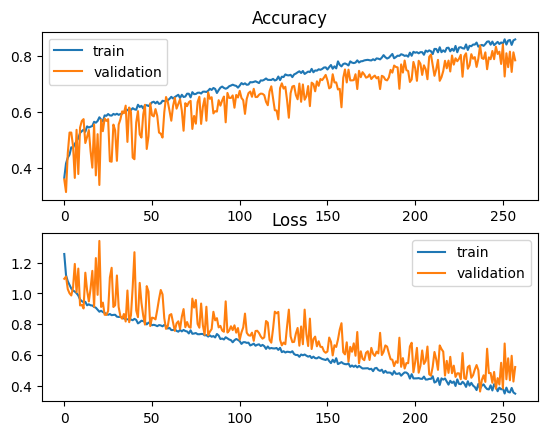

In [194]:
plt.subplot(2, 1, 1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


## 동적 Class 분류
- 마찬가지로 LGBM

In [110]:
dynamic_data = train_data[train_data['is_dynamic'] == 1].reset_index(drop=True)
x_dynamic = dynamic_data.drop(columns=['Activity_dynamic', 'is_dynamic']).values
y_dynamic = dynamic_data['Activity_dynamic'].values

In [112]:
from lightgbm import LGBMClassifier
my_seed_everywhere(42)
model = LGBMClassifier(random_state=42)
# 검증하기
cv_score = cross_val_score(model, x_dynamic, y_dynamic, cv=10)

# 확인
print(cv_score)
print('평균:', cv_score.mean())
print('표준편차:', cv_score.std())

[0.98802395 0.99201597 0.99001996 0.99201597 0.98602794 0.974
 1.         1.         1.         1.        ]
평균: 0.992210379241517
표준편차: 0.00796839307677172


In [113]:
# model2_2 는 동적 Class 분류
my_seed_everywhere(42)
model2_2 = LGBMClassifier(random_state=42)
model2_2.fit(x_dynamic, y_dynamic)

LGBMClassifier(random_state=42)

In [196]:
model2_1.predict( x_test ).argmax(axis=1) + 3

46/46 [==============================] - 0s 2ms/step


array([4, 4, 3, ..., 3, 3, 3])

In [197]:
def my_model_predict(x):
    """
    params:
        x : DataFrame. Features
    ret:
        y_pred : numpy array

    model1 : 정적 동적 구분 
    model2-1 : 정적으로 구분한 것을 세부 Class 분류 
    model2-1 : 동적으로 구분한 것을 세부 Class 분류 
    """
    # 정적, 동적 예측 결과 저장
    x['is_dynamic'] = model1.predict(x.values)

    # 정적과 동적 예측 결과에 따라 나누기
    # reset_index로 원래의 index 를 column으로 빼서 나중에 concat 후 사용
    temp_static = x[x['is_dynamic'] == 0].reset_index()
    temp_dynamic = x[x['is_dynamic'] == 1].reset_index()

    # 정적, 동적 별로 각 Class 예측
    # 정적 Class 는 결과값 + 3!!
    # temp_static['label'] = model2_1.predict( temp_static.drop(['is_dynamic', 'index'], axis=1) ) + 3
    temp_static['label'] = model2_1.predict( temp_static.drop(['is_dynamic', 'index'], axis=1) ).argmax(axis=1) + 3 # deeplearning model
    temp_dynamic['label'] = model2_2.predict( temp_dynamic.drop(['is_dynamic', 'index'], axis=1) )

    # 각 예측 결과를 합치고, index로 정렬
    result_df = pd.concat([temp_static, temp_dynamic], axis=0).sort_values(by='index').set_index('index')

    # y_pred 뽑기
    y_pred = result_df['label'].values

    x.drop('is_dynamic', axis=1, inplace=True)

    return y_pred

In [198]:
y_pred = my_model_predict(x_test)
y_pred

27/27 [==============================] - 0s 3ms/step


array([4, 4, 0, ..., 2, 3, 2])

In [199]:
result = pd.DataFrame(y_pred, columns=['Activity']).reset_index(names='ID')
result

,ID,Activity
0,0,4
1,1,4
2,2,0
3,3,5
4,4,3
...,...,...
1466,1466,3
1467,1467,5
1468,1468,2
1469,1469,3


In [200]:
save_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/Kaggle_Competition/submission/'
temp = pd.read_csv(save_path + 'submssion_5.csv')
(temp['Activity'] != result['Activity']).sum()

383

In [152]:
save_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/Kaggle_Competition/'
result.to_csv(save_path + "DL_1.csv", index=False)